In [1]:
from models import AnnLassoRegression, AnnLassoClassification, LinearModel
import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import multiprocessing
import warnings
warnings.filterwarnings("ignore")
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')

In [ ]:
def simulate(index, X, s, lambda_qut, cont):
    y, features = utils.generate_linear_data(X, s)
    pesr = {}
    
    if cont['linear old']:
        model = LinearModel(penalty=1, lambda_qut=lambda_qut)
        model.fit(X, y)
        pesr["linear old"] = set(model.important_features[1]) == set(features)
    else:
        pesr["linear old"] = 0.0

    if cont['neural old']:
        model = AnnLassoRegression(penalty=1, lambda_qut=lambda_qut)
        model.fit(X, y)
        pesr["neural old"] = set(model.important_features[1]) == set(features)
    else:
        pesr["neural old"] = 0.0

    if cont['linear new']:
        model = LinearModel(penalty=0, lambda_qut=lambda_qut)
        model.fit(X, y)
        pesr["linear new"] = set(model.important_features[1]) == set(features)
    else:
        pesr["linear new"] = 0.0

    if cont['neural new']:
        model = AnnLassoRegression(penalty=0, lambda_qut=lambda_qut)
        model.fit(X, y)
        pesr["neural new"] = set(model.important_features[1]) == set(features)
    else:
        pesr["neural new"] = 0.0

    return pesr

# Assuming X is loaded outside the loop
X = pd.read_csv(f"data/linear/n{n}/X-n{n}-p300.csv")
X_tensor = utils.X_to_tensor(X)
lambda_qut = utils.lambda_qut_regression(X_tensor, utils.Custom_act_fun())

names = ["linear old", "neural old", "linear new", "neural new"]
cont = {name: True for name in names}
pesr_means = {name: [] for name in names}

for s in range(35):
    pesr = {name: [] for name in names}
    
    with Pool(processes=4) as pool:  # Adjust the number of processes according to your machine's capabilities
        results = pool.starmap(simulate, [(m, X.copy(), s, lambda_qut, cont.copy()) for m in range(100)])
    
    for result in results:
        for name in names:
            pesr[name].append(result[name])

    for name in names:
        mean_value = np.mean(pesr[name])
        pesr_means[name].append(mean_value)
        cont[name] = mean_value != 0.0

    df = pd.DataFrame(pesr_means, index=range(s + 1))
    df.to_csv(f"data/linear/n{n}/PESR.csv", index=False)


In [2]:
for n in [10, 40, 70, 130]:
    X = pd.read_csv(f"data/linear/n{n}/X-n{n}-p300.csv")
    X_tensor = utils.X_to_tensor(X)
    lambda_qut = utils.lambda_qut_regression(X_tensor, utils.Custom_act_fun())

    names = ["linear old", "neural old", "linear new", "neural new"]
    cont = {name: True for name in names}
    pesr_means = {name: [] for name in names}

    for s in range(35):
        pesr = {name: [] for name in names}
        
        for m in range(3):
            y, features = utils.generate_linear_data(X, s)

            if cont['linear old']:
                model = LinearModel(penalty = 1, lambda_qut = lambda_qut)
                model.fit(X, y)
                pesr["linear old"].append(set(model.important_features[1]) == set(features))
            else:
                pesr["linear old"].append(0.0)

            if cont['neural old']:
                model = AnnLassoRegression(penalty = 1, lambda_qut = lambda_qut)
                model.fit(X, y)
                pesr["neural old"].append(set(model.important_features[1]) == set(features))
            else:
                pesr["neural old"].append(0.0)

            if cont['linear new']:
                model = LinearModel(penalty = 0, lambda_qut = lambda_qut)
                model.fit(X, y)
                pesr["linear new"].append(set(model.important_features[1]) == set(features))
            else:
                pesr["linear new"].append(0.0)

            if cont['neural new']:
                model = AnnLassoRegression(penalty = 0, lambda_qut = lambda_qut)
                model.fit(X, y)
                pesr["neural new"].append(set(model.important_features[1]) == set(features))
            else:
                pesr["neural new"].append(0.0)

        for name in names:
            pesr_means[name].append(np.mean(pesr[name]))
            cont[name] = np.mean(pesr[name]) != 0.0

        df = pd.DataFrame(pesr_means, index=range(s + 1))
        df.to_csv(f"data/linear/n{n}/PESR.csv", index=False)

KeyboardInterrupt: 

<h1><center>Regression - Linear data</center></h1>

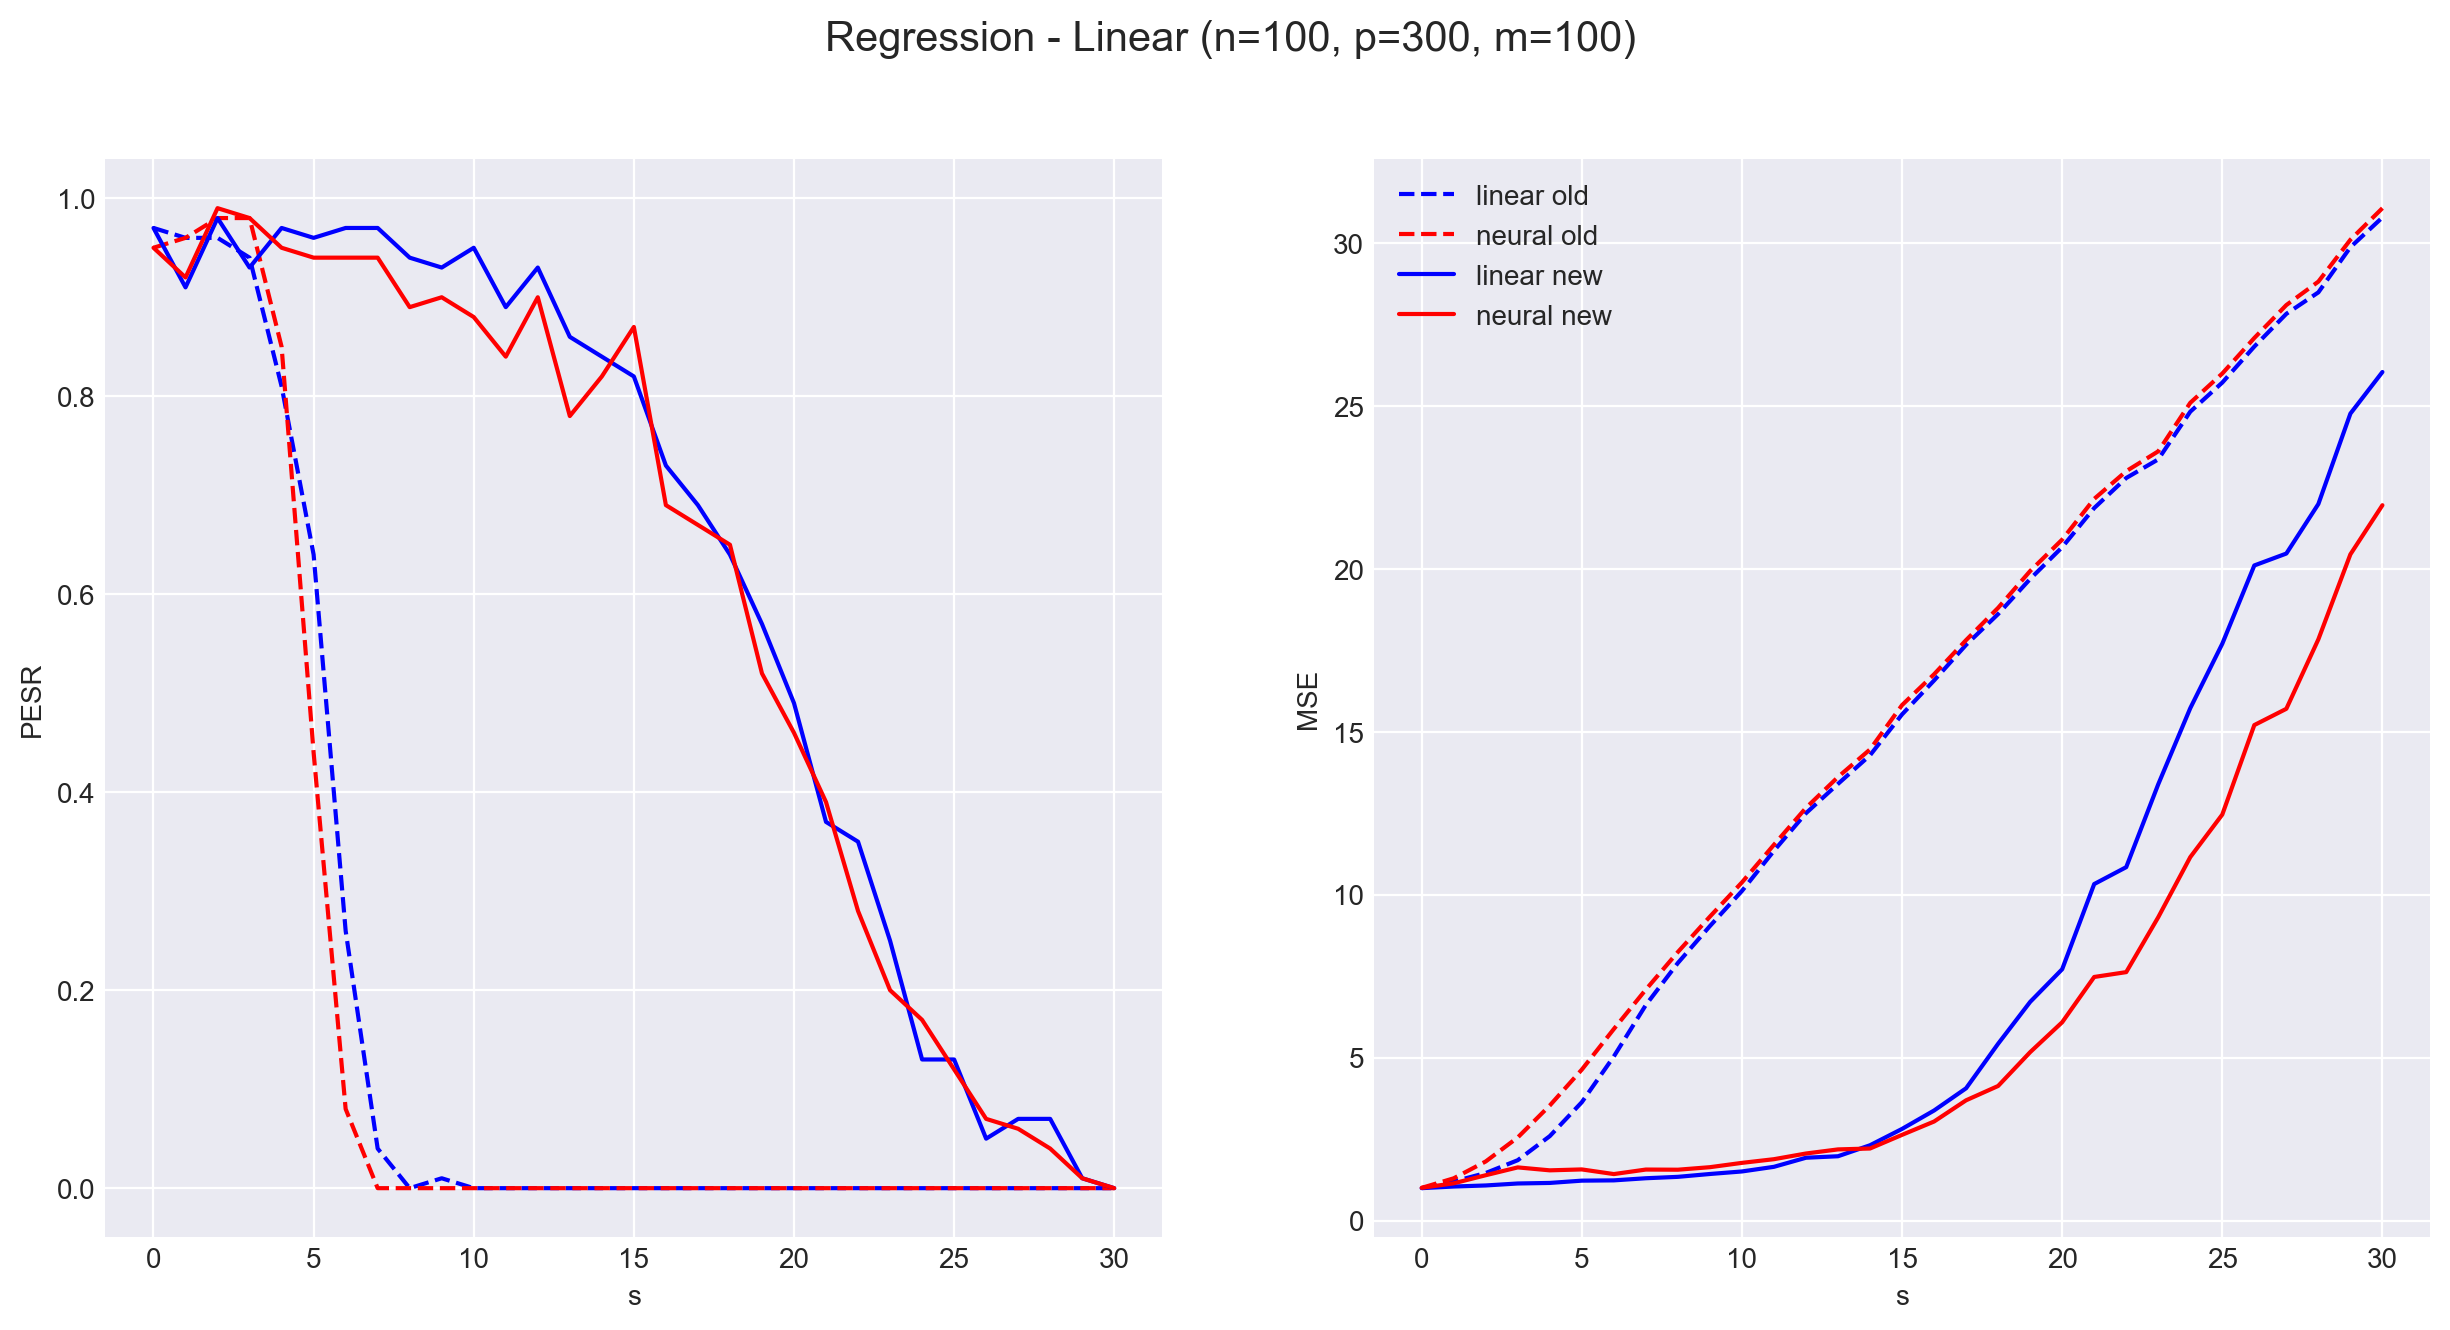

In [18]:
errors = pd.read_csv("data/linear/n100/results/errors.csv")
PESR = pd.read_csv("data/linear/n100/results/PESR.csv")
names = PESR.keys()
styles = ['b--', 'r--', 'b-', 'r-'] # Red for neural, dotted for old penalty

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), dpi=200)

for name, style in zip(names, styles):
    ax1.plot(np.arange(31), PESR[name], style)
    ax2.plot(np.arange(31), errors[name], style, label=name)

ax1.set_xlabel("s")
ax1.set_ylabel("PESR")

ax2.set_xlabel("s")
ax2.set_ylabel("MSE")
ax2.legend()

plt.suptitle("Regression - Linear (n=100, p=300, m=100)", fontsize=15)
plt.show()

<h1><center>Regression - Nonlinear data</center></h1>

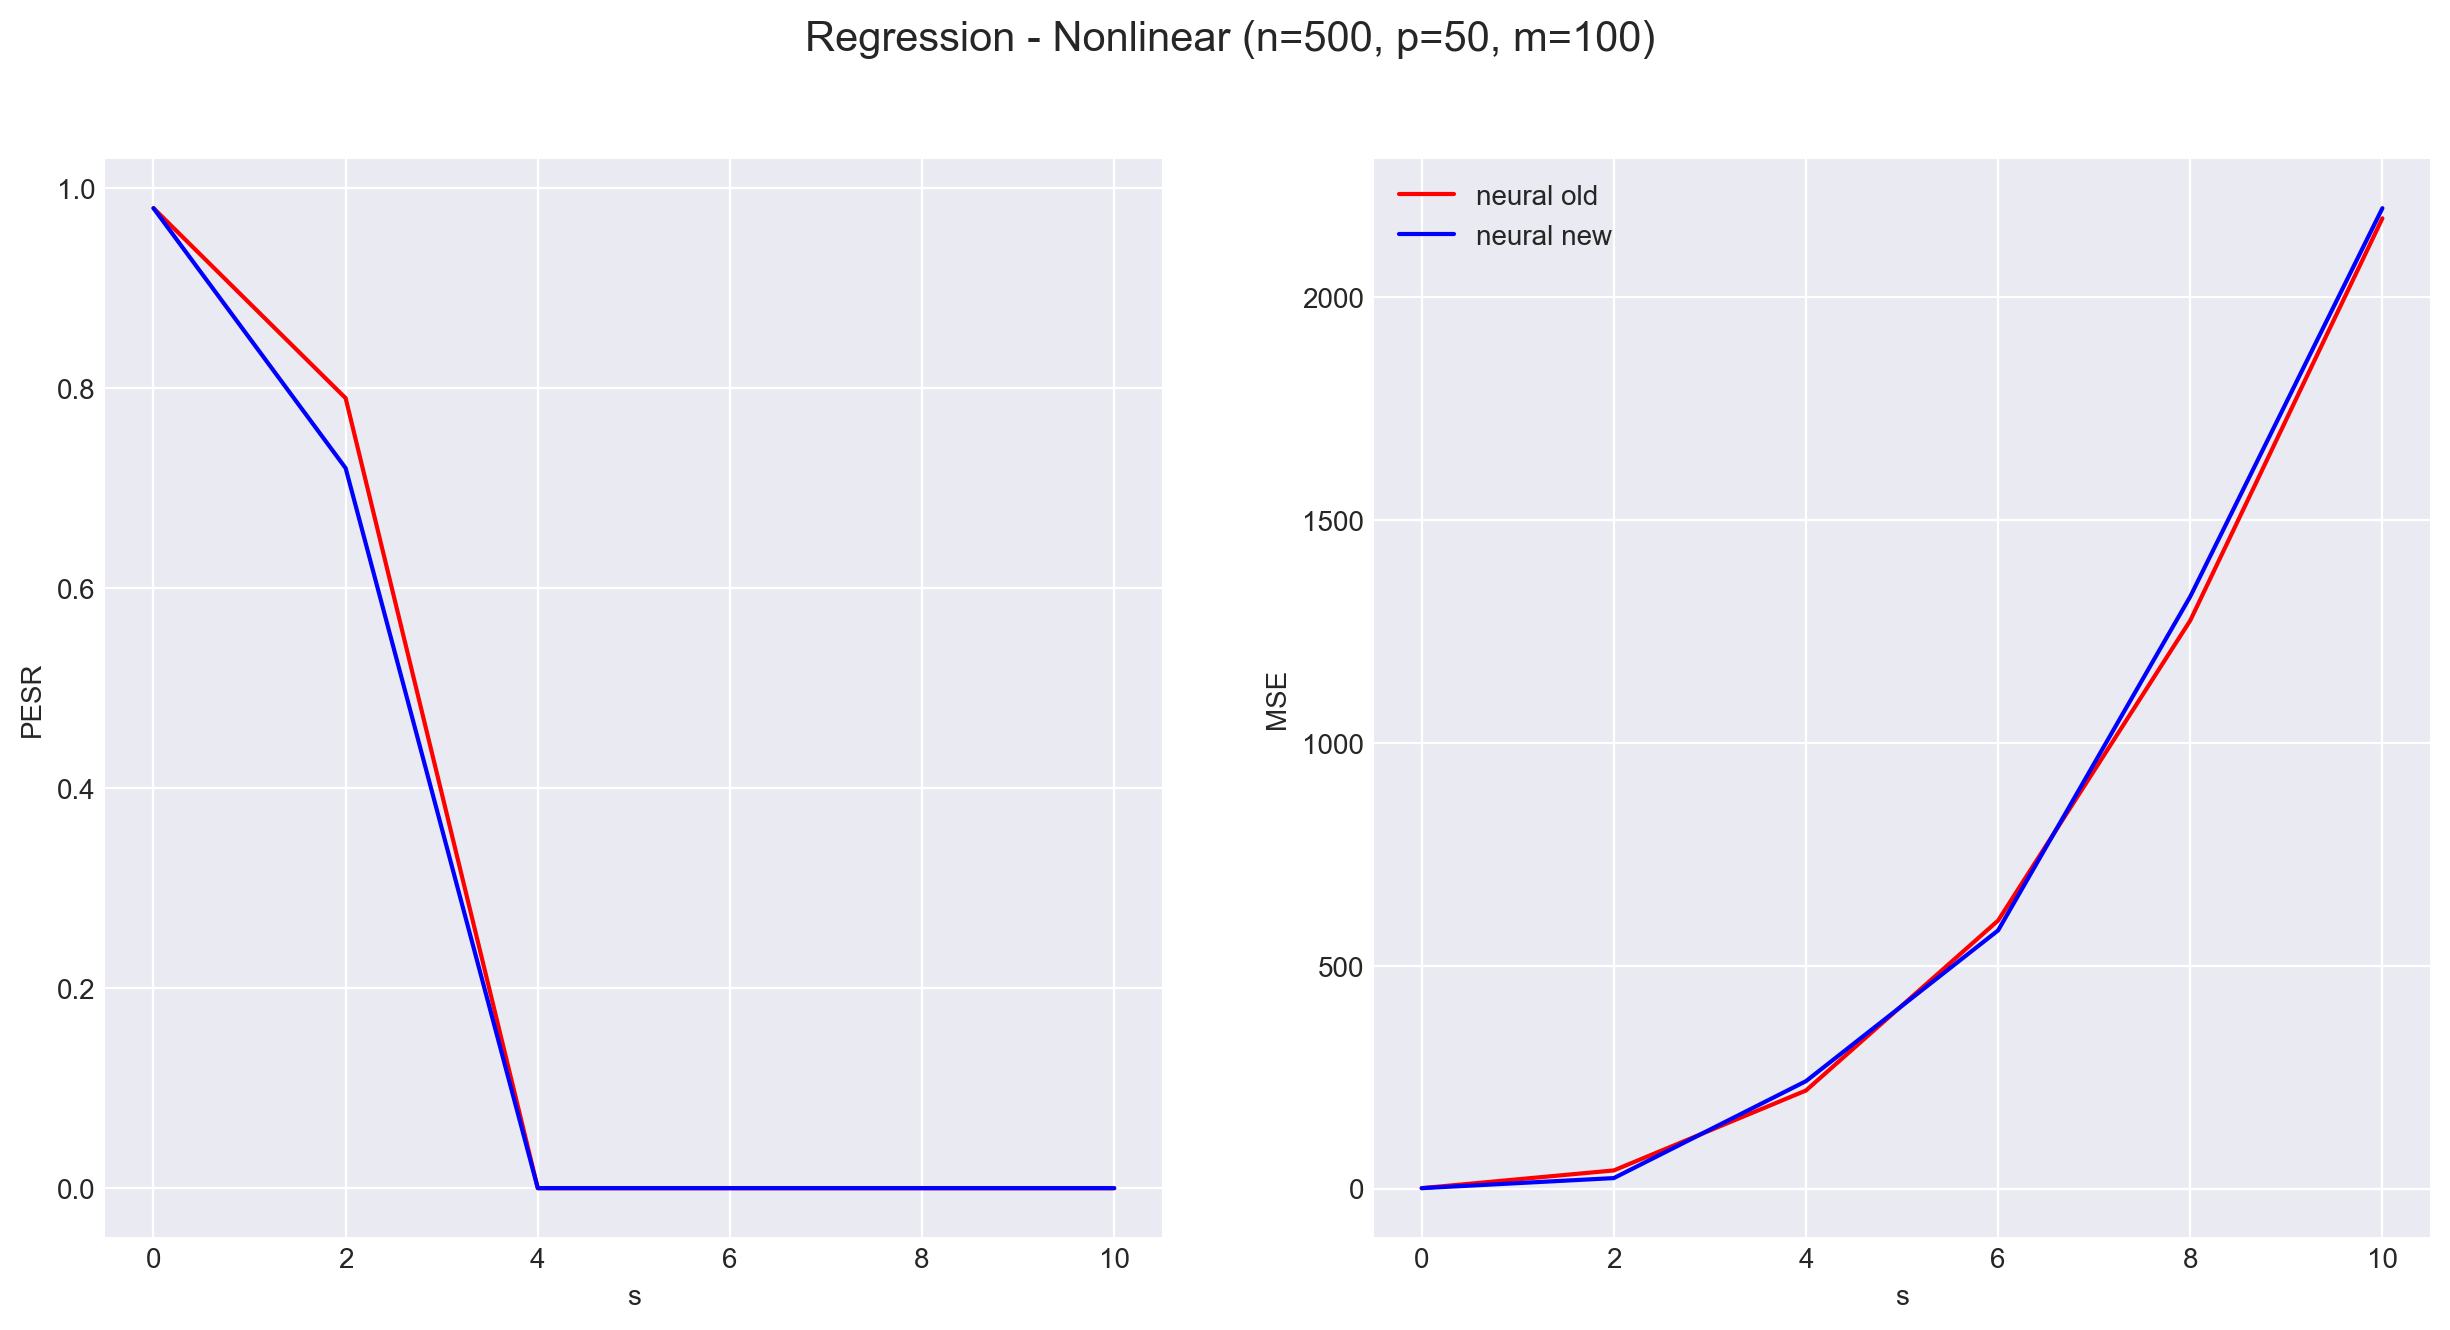

In [19]:
errors = pd.read_csv("data/nonlinear/n500/Results/errors.csv")
PESR = pd.read_csv("data/nonlinear/n500/Results/PESR.csv")
names = PESR.keys()

styles = ['r-', 'b-'] # red for old blue for new

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), dpi=200)

for name, style in zip(names, styles):
    ax1.plot(np.arange(0, 12, 2), PESR[name], style)
    ax2.plot(np.arange(0, 12, 2), errors[name], style, label=name)

ax1.set_xlabel("s")
ax1.set_ylabel("PESR")

ax2.set_xlabel("s")
ax2.set_ylabel("MSE")
ax2.legend()

plt.suptitle("Regression - Nonlinear (n=500, p=50, m=100)", fontsize=15)
plt.show()

<h1><center>Classification</center></h1>

In [4]:
from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.metrics import accuracy_score
import os
from tqdm import tqdm

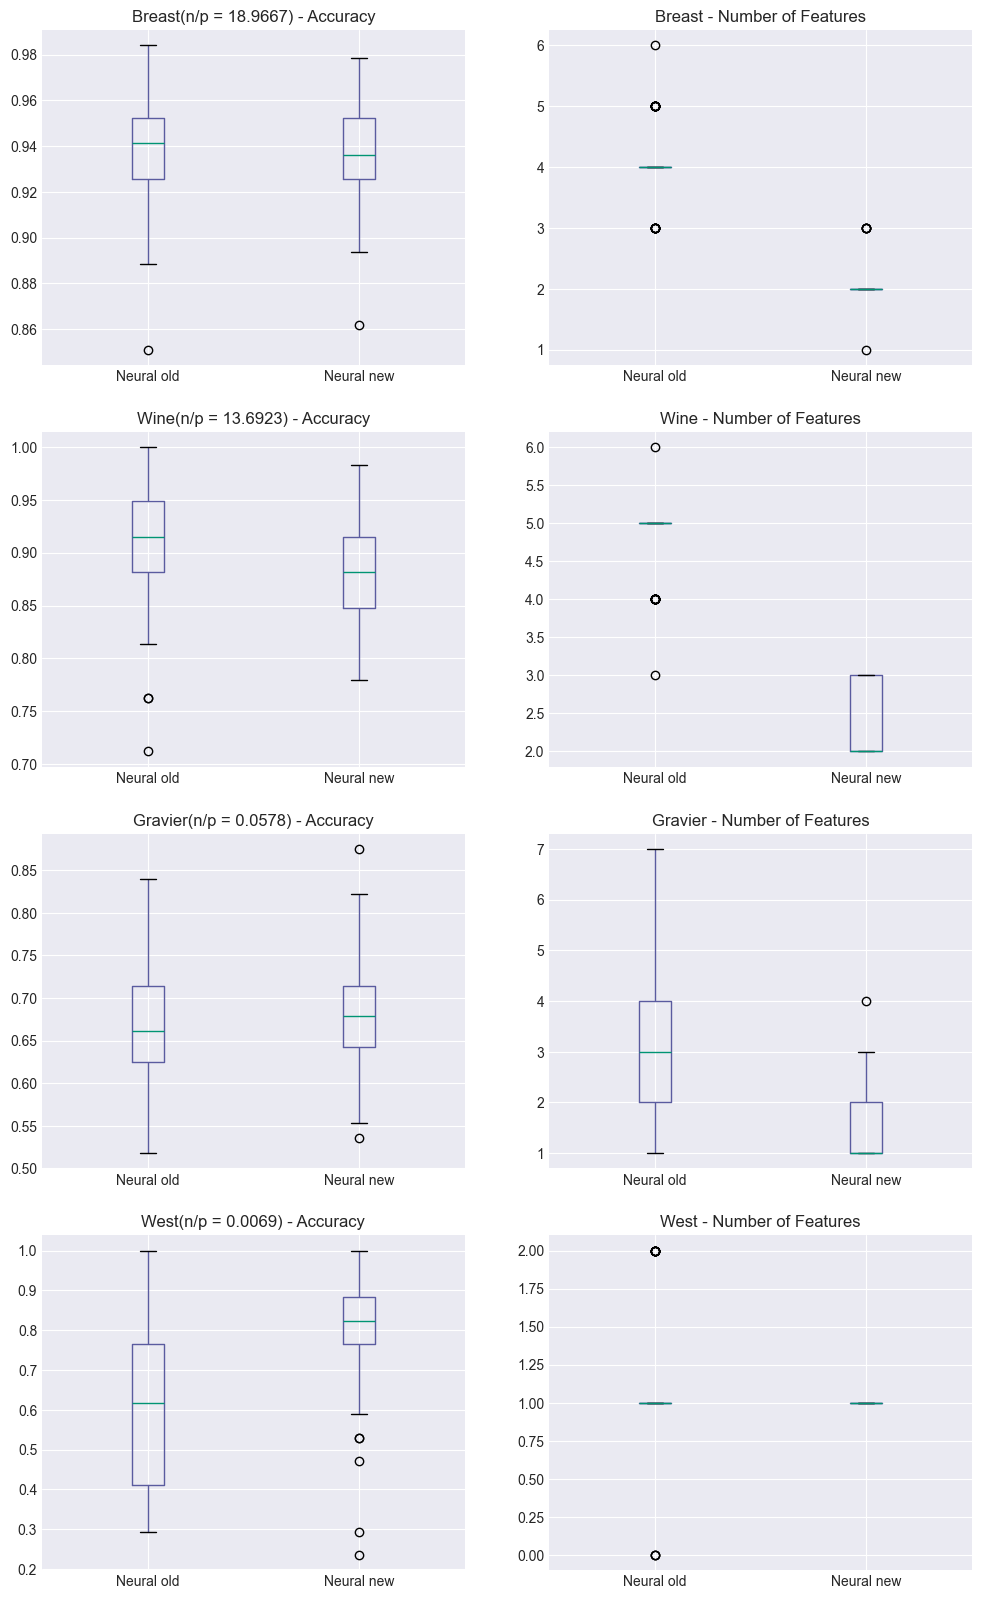

In [20]:
names = ["Breast", "Wine", "Gravier", "West"]
ratio = {"Breast": 18.9667, "Wine": 13.6923, "Gravier": 0.0578, "West": 0.0069}

fig, axs = plt.subplots(4, 2, figsize=(12, 20))


for name, (ax1, ax2) in zip(names, axs):
    accuracies = pd.read_csv(f'data/classification/{name}/Results/accuracies.csv')
    n_features = pd.read_csv(f'data/classification/{name}/Results/selected_features.csv')

    accuracies.boxplot(ax=ax1)
    ax1.set_title(f'{name}(n/p = {ratio[name]}) - Accuracy')

    n_features.boxplot(ax=ax2)
    ax2.set_title(f'{name} - Number of Features')

plt.show()
